In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plotPrefByCat(cat,df,nameDict):
    display(allRatings.groupby(cat).size())
    for cName in df[cat].unique():
        plotTraitCorrel(df[df[cat]==cName]).set_title(f"{nameDict[cName]} prefrences\n")
        plt.show()

def getRowCorrel(keys,by,df):
    return df[keys].corr().drop(by)[by].values
    
def plotTraitCorrel(df):    
    ratingHm = pd.DataFrame.from_dict(
        {'Other Rating': getRowCorrel(list(otherRatings.columns.values) + ['matchRatio'],'matchRatio',df),
         'Self Rating': getRowCorrel(list(selfRatings.columns.values) + ['matchRatio'],'matchRatio',df)
        }
        ,orient='index',
        columns=[fullName(e) for e in personalityVector])


    ratingHm = ratingHm.round(3)
    fig, ax = plt.subplots(figsize=(15,3))
    g = sns.heatmap(ratingHm,vmin =-1, vmax=1,annot=True,fmt='g',ax=ax,linewidths=0.1,cmap='coolwarm')
    g.set_title("Match ratio correlation with ratings\n")
    g.set_yticklabels([e._text.replace(" ","\n") for e in g.get_yticklabels()],rotation=0)
    return g

def strMean(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [3]:
raceKeys ={1:'Black/African American',2:'White/Caucasian',
                                 3:'Latino/Hispanic American',4:'Asian/Pacific Islander/Asian-American',
                                 5:'Native American',6:'Other'}
genderKeys = {0:'Female',1:'Male'}

feildKeys = {1:'Law',2:'Math',3:'Social Science, Psychologist',4:'Medical Science, Pharmaceuticals, and Bio Tech',
             5:'Engineering'  ,6:'English/Creative Writing/ Journalism',7:'History/Religion/Philosophy',
             8:'Business/Econ/Finance' ,9:'Education, Academia' ,10:' Biological Sciences/Chemistry/Physics',
             11:' Social Work' ,12:' Undergrad/undecided' ,13:'Political Science/International Affairs'
             ,14:'Film',15:'Fine Arts/Arts Administration',16:'Languages',17:'Architecture',18:'Other'}

In [4]:
speedDating = pd.read_csv("Speed Dating Data.csv",encoding = "ISO-8859-1",thousands=',')
speedDating['idg'] = speedDating['idg'].astype(int)
speedDating['race'] = speedDating['race'].fillna(6).astype(int)

In [5]:
study = ['iid','id','idg','condtn','round','position','positin1','order','partner','pid','wave']
interests =  ["sports" ,"tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga"]
expectations = ['exphappy','expnum','match_es','goal','imprace','imprelig']
demographic = ['gender','age','field','undergra','race','career','career_c','field','field_cd','zipcode','income','mn_sat','tuition','from']
followUp = [e for e in speedDating.columns.values if re.search("^\S*_\d$",e) != None] + ['length']
selfRating =[e for e in speedDating.columns.values if re.search("^\S*_s$",e) != None]
partner = ([e for e in speedDating.columns.values if re.search("_o",e) != None] + ['samerace','int_corr','match'])
scoreCard = ["dec","attr","sinc","intel","fun","amb","shar","like","prob","met"]
postStudy = ['date','them_cal', 'you_call']

None

In [6]:
categories = list(zip([scoreCard , selfRating ,followUp , interests , partner , study , demographic , expectations , postStudy],
                ['Score card' , 'Self rating' ,'Follow up' , 'interests' , 'partner' , 'study' , 'demographic' , 'expectations' , 'Post study']))

def recCount(df):
    return df.shape[0] * df.shape[1]

def printNas(df):
    print(f"Total % Na :   { ((df.isna().sum().sum()/recCount(df))*100):.1f}")
    for cat,name in categories:
        print(f"{name}:   { ((df[cat].isna().sum().sum()/recCount(df[cat]))*100):.1f}")
        
def naDf(df,name="?"):
    d = {'Total':[((df.isna().sum().sum()/recCount(df))*100)]}
    d.update({name:[((df[cat].isna().sum().sum()/recCount(df[cat]))*100)]for cat,name in categories})
    return pd.DataFrame.from_dict(d).rename(index={0:name})

## Feature grouping

Before either pruning features or training models i though it would help to group features by type.

after looking through the study I found 9 groups of features:

    * Study data - such as what group they were in, it is important to note that these features are 
        not sutible for inputs to ML models.
    
    * Interests - such as what hobbies the participants liked.
    
    * Expectations - what the participant wanted to get out of the experiment aswell as what prefrences they have.
    
    * Demographic - race, zip-code, income, field of study etc.
    
    * Follow Up Questions - these are questions the rearchers recorded both at the event 
        and via mail after (nulls are more common in these columns).
    
    * Self Rating - Questions the participants answed about themselves.
    
    * Partner - Data about the partner for that "Speed Date".
    
    * Score card - Ratings of the other partners trait aswell as if they "matched".
    
    * Post Study - Questions about the study in hindsight, e.g. if they called/were called by a date.


## Adding Wave info

Each wave of speed dating had different prefrence scales (how the scorecards were filled in) aswell as different samples such as only undergraduates, I have opted to label each record with this data.

In [7]:
speedDating['prefScale'] = speedDating['wave'].map(lambda x : '1-10scale' if 5< x  <10 else '100pt')
variations = {5:'undergrads',12:'budget',13:'differentMC'}
speedDating['variation'] = speedDating['wave'].map(lambda x : variations[x] if x in variations else 'normal')

In [8]:
def UniqueCat(df,col):
    return [naDf(speedDating[speedDating[col]==n],col + "[ " + n+" ]") for n in speedDating[col].unique()]

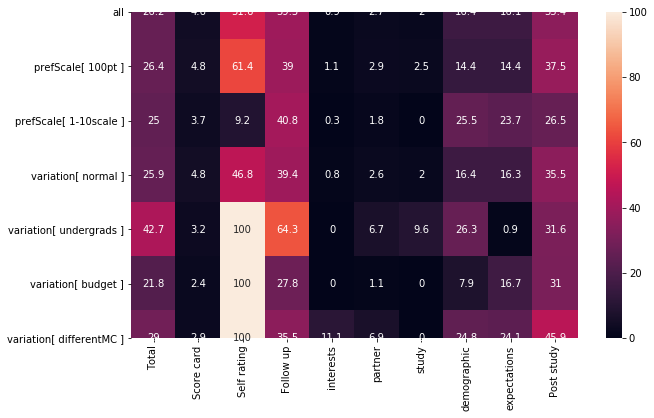

In [9]:
naPerCat = pd.concat([naDf(speedDating,'all')] + UniqueCat(speedDating,'prefScale')+ UniqueCat(speedDating,'variation')).round(1)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(naPerCat,vmin =0, vmax=100,annot=True,fmt='g',ax=ax)
None

## Nulls

Now that I have grouped the variables by their type and labled the records where some other condition (such as eveyone being an undergrad) we can see the true Null percentages.

It seems that no one in any of the "variations" filled in their self rating and 46% of people in the normal category of waves did not fill in all the information.

The black coloured correlation boxes show the variables that had a null rate of <= 10.

By the looks of this, _self-rating_, _follow up_ and _post study_ all seem like poor variables to use as the have a 30-50% null rate and such a high number may bias the data and imputing wont fix this issue as the mean may be what people who are bothered to fill in all of the forms would answer.

Dropping the nulls in another option however we have another issue, each record has reference to up to 20 other members of the study, deleting one participant of a "group" (a row wise deletion) may hurt the accuracy of eveyone in the group as they are now referencing a non existent record.

It seems the best way to proceed is to remove columns of low interest or that may be hard to gather in a real world situation.

## Model considerations

As we previously discussed, an algorithim could actually get the average rating of a participants score based on the mean of all of the peer ratings. This would be interesting to see and compare with the participant's self ratings, aswell as which traits by potential partners deemed more important as opposed to self reported traits.

To do so deleting one person in a group of people may cause issues because while their records may not be sutible for a model, their ratings of others may be important.

Furthermore, questions such as what the participants thought the day after the study versus 1 month later would be hard to incorporate into useful data pipelines (i.e. in a dating app such a Tinder), So I am hesitant to make my model depend on these. However, demographic infomation and self + prospecive partner ratings would be easier information to come by.

## Waves

Each wave required each individual male participant to have a four minute date with every female participant. This allowed me to take down all the ratings of what women and men within a wave rated each other.

To achieve this, I used panda's groupby function and then add these ratings back to the dataframe.

In [10]:
def CountList(df,col):
    return [(n,speedDating[speedDating[col]==n].shape[0]) for n in speedDating[col].unique()]

names,count = zip(*CountList(speedDating,'prefScale'))
print("Records by Prefrence Scale")
display(pd.DataFrame(data={"count":count},index=names))
print("\nRecords by Variation")
names,count = zip(*CountList(speedDating,'variation'))
display(pd.DataFrame(data={"count":count},index=names))

Records by Prefrence Scale


,count
100pt,6816
1-10scale,1562



Records by Variation


,count
normal,7616
undergrads,190
budget,392
differentMC,180


In [11]:
sdPruned = speedDating[(speedDating['prefScale'] == '100pt') & (speedDating['variation'] == 'normal')]
display(f"null value percentage: {(sdPruned.isna().sum().sum() / recCount(sdPruned)) *100}%")

'null value percentage: 26.161249264236087%'

In [12]:
personalityVector = ["attr","sinc","intel","fun","amb"]
otherRatings = sdPruned.groupby('pid')[personalityVector].mean()
otherRatings.columns = ["omr_" + e for e in otherRatings.columns]

selfPV = [e +"3_s" for e in personalityVector]
selfRatings = sdPruned.groupby('iid')[selfPV].mean()
selfRatings.columns = ["self_"+e for e in selfRatings.columns]

In [13]:
allRatings = otherRatings.join(selfRatings)
allRatings['matchRatio'] = sdPruned.groupby('iid')['dec_o'].mean()

demographics = sdPruned.groupby('iid')['gender','race'].agg(pd.Series.mode)
demographics['career_c'] = sdPruned.groupby('iid')['career_c'].agg(strMean)
allRatings = allRatings.join(demographics)


In [14]:
##write out averaged other ratings
for col in otherRatings.columns:
    sdPruned[col] = sdPruned['iid'].map(lambda x : otherRatings.loc[x,col]) 

sdPruned[otherRatings.columns]

sdPruned.to_csv("SpeedDatingPruned.csv")

In [15]:
def fullName(name):
    if "attr" in name:
        return "Attractive"
    elif "sinc" in name:
        return "Sincere"
    elif "intel" in name:
        return "Intelligent"
    elif "fun" in name:
        return "Fun"
    elif "amb" in name:
        return "Ambitious"
    elif "shar" in name:
        return "Shared Hobbies"
    elif "matchRatio" in name:
        return "Match\nRatio"
    return name

def radarPlot(df,c='b',ax=None,**kwargs):
    labels = df.columns.values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    vals = df.mean()
    angles=np.concatenate((angles,[angles[0]]))
    vals=np.concatenate((vals,[vals[0]]))

    if not(ax):
        fig = plt.figure()
        ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, vals, 'o-', linewidth=2,c=c,**kwargs)
    ax.fill(angles, vals, alpha=0.1,c=c)
    ax.set_thetagrids(angles * 180/np.pi, [fullName(e)  for e in df.columns.values])
    plt.yticks(range(1,11))
    ax.grid(True)
    return ax

def plotRatings(df):
    for k in df.columns:
        g =sns.kdeplot(df[k])
        g.set_xticks(range(1,11))
        g.set_xlim((1,10))
    plt.legend(title='Rating', loc='upper left', labels=[fullName(e)  for e in df.columns.values])
    plt.show()

def plotPersVilo(df1,df2):
    fig, axArr = plt.subplots(1,5,gridspec_kw=dict(wspace=1),figsize=(20,6))
    for ax,f1,f2 in zip(axArr,df1.columns,df2.columns):
        g = sns.violinplot(ax=ax,palette=['b','r'],data=[df1[f1],df2[f2]])
        g.set_title(fullName(f1))
        g.set_ylabel("")
        g.set_yticks(range(1,11))
        g.set_xticklabels(['self','other'])
        
def plotPersViloGrid(df1,df2):
    fig, axGrid = plt.subplots(5,2,gridspec_kw=dict(wspace=0.25,hspace=0.25),figsize=(5,25))
    for i in [0,1]:
        for axArr,f1,f2 in zip(axGrid,df1[i],df2[i]):
            g = sns.violinplot(ax=axArr[i],palette=['b','r'],data=[df1[i][f1],df2[i][f2]])
            g.set_title(genderKeys[i]+"\n"+fullName(f1)),g.set_ylabel(""),g.set_yticks(range(1,11)),g.set_xticklabels(['self','other']) 

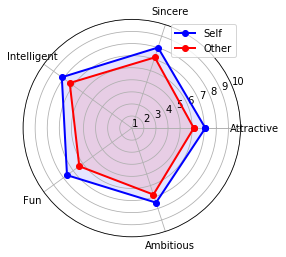

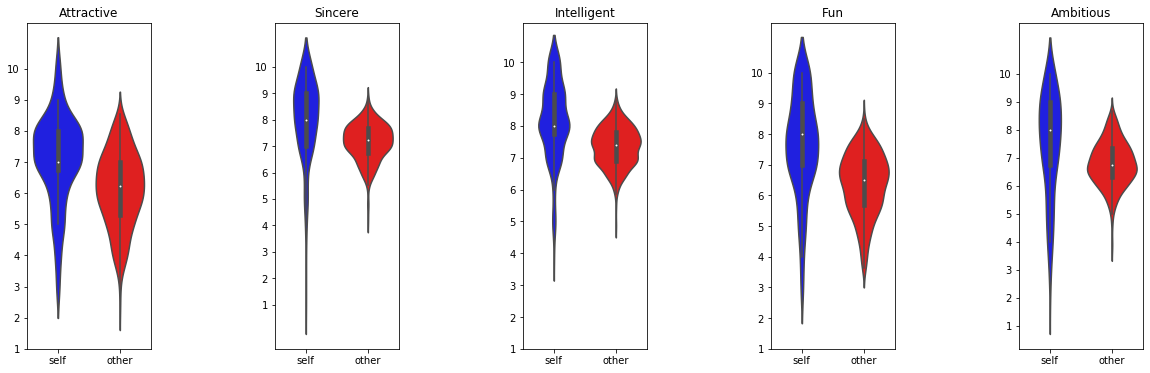

In [16]:
ax = radarPlot(selfRatings,c='b',label='Self')    
radarPlot(otherRatings,c='r',ax=ax,label='Other'),plt.legend(),plt.show()
plotPersVilo(selfRatings,otherRatings),plt.show()
None

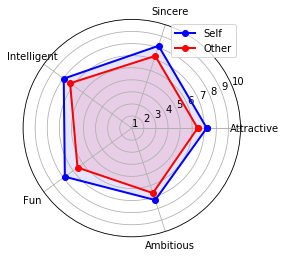

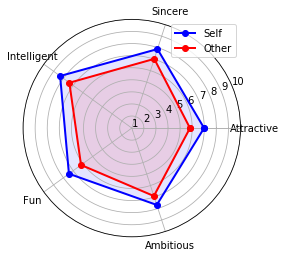

In [17]:
gSelfR = [allRatings[allRatings['gender'] == g][selfRatings.columns] for g in [0,1]]
gOtherR = [allRatings[allRatings['gender'] == g][otherRatings.columns] for g in [0,1]]

for s,o,name,i in zip(gSelfR,gOtherR, ["Female","Male"],range(0,2)):
    ax = radarPlot(s,c='b',label='Self')    
    radarPlot(o,c='r',ax=ax,label='Other'),plt.legend(loc='upper right'),plt.show()

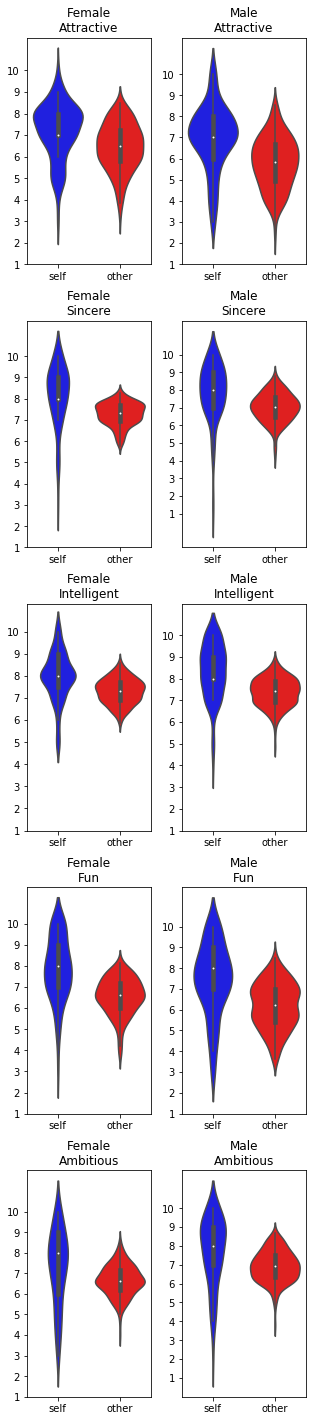

In [18]:
plotPersViloGrid(gSelfR,gOtherR)
plt.show()

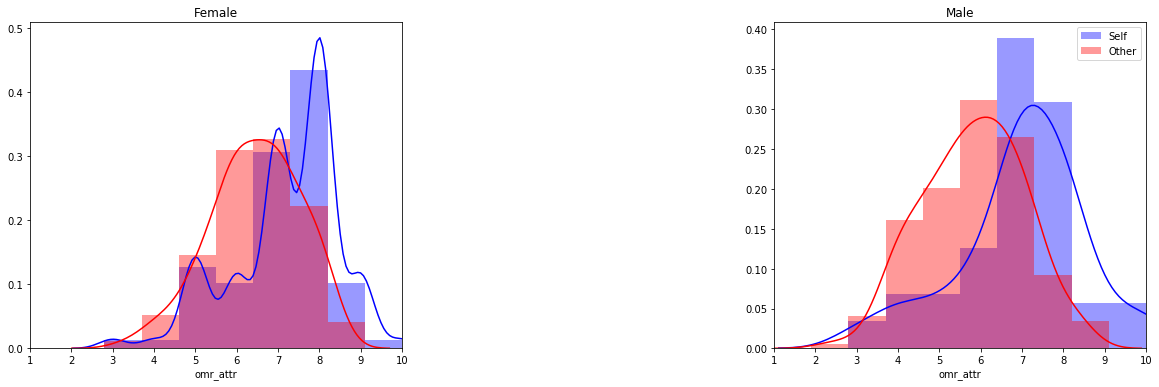

In [19]:
fig, axArr = plt.subplots(1,2,gridspec_kw=dict(wspace=1),figsize=(20,6))

for s,o,name,ax in zip(gSelfR,gOtherR, ["Female","Male"],axArr):
    sns.distplot(s['self_attr3_s'].dropna(),ax=ax,bins=10,label='Self',color='b',hist_kws={'range':(1,10)})
    sns.distplot(o['omr_attr'].dropna(),ax=ax,bins=10,label='Other',color='r',hist_kws={'range':(1,10)}).set_title(name)
    ax.set_xlim(1,10)
plt.legend()
plt.show()


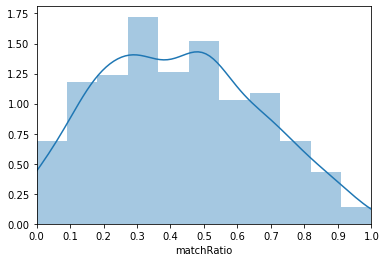

In [20]:
g =sns.distplot(allRatings['matchRatio'])
g.set_xticks(np.arange (0.0, 1.1, 0.1)),g.set_xlim((0,1))
plt.show()
None

## Average Match Ratio

The average `match` rate for the sample population was around 40% with some zero stacking.

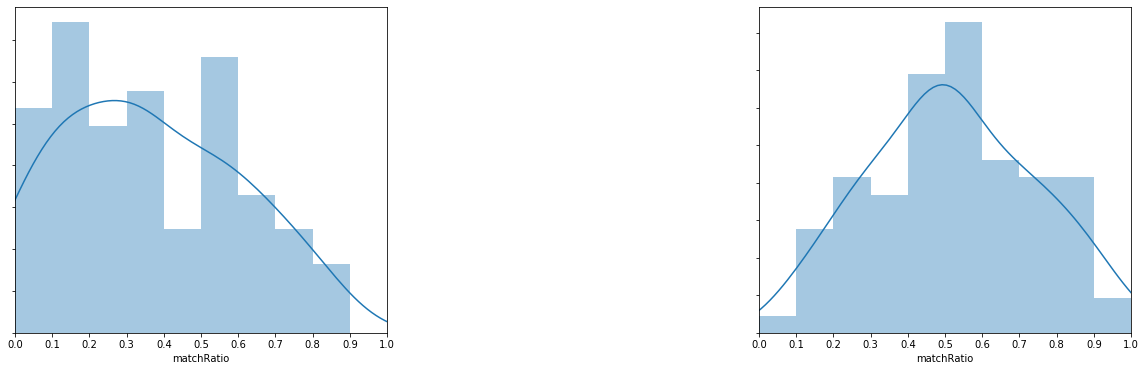

Male mean: 36.0% 
Female mean: 51.8%


In [21]:
female,male = [allRatings[allRatings['gender'] == e].dropna()['matchRatio'] for e in [0,1]]


fig, axArr = plt.subplots(1,2,gridspec_kw=dict(wspace=1),figsize=(20,6))
g = sns.distplot(male,label='Male',ax=axArr[0],hist=True,bins=10,hist_kws={'range':(0.0,1.0)})
g.set_xticks(np.arange (0.0, 1.1, 0.1)),g.set_yticklabels([]),g.set_xlim((0,1))
g =sns.distplot(female,label='Female',ax=axArr[1],hist=True,bins=10,hist_kws={'range':(0.0,1.0)})
g.set_xticks(np.arange (0.0, 1.1, 0.1)),g.set_yticklabels([]),g.set_xlim((0,1))
plt.show()
print(f"Male mean: {(male.mean()*100):.1f}% \nFemale mean: {(female.mean()*100):.1f}%")


## Match ratio by gender

After segmenting into gender we find that no men had everyone in their wave agree to match them, whereas a small amount of women had everyone match them.
Men averaged a 36% match rate, whereas women averaged a 51% match rate.

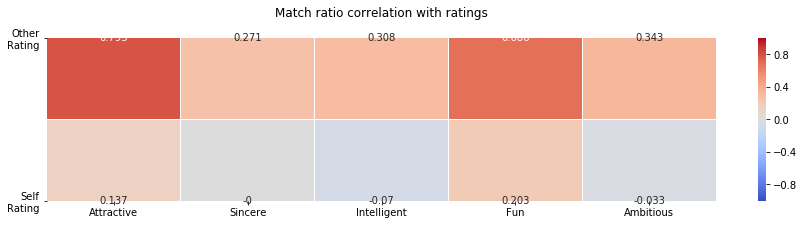

In [22]:
plotTraitCorrel(allRatings)
None

gender
0    190
1    193
dtype: int64

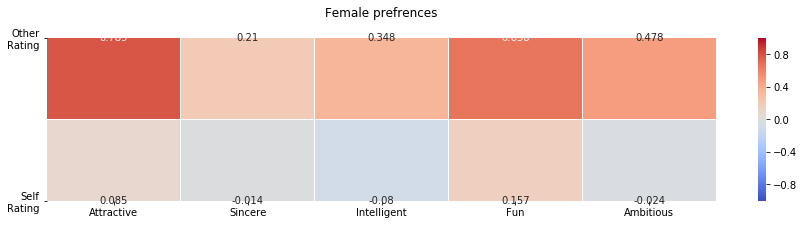

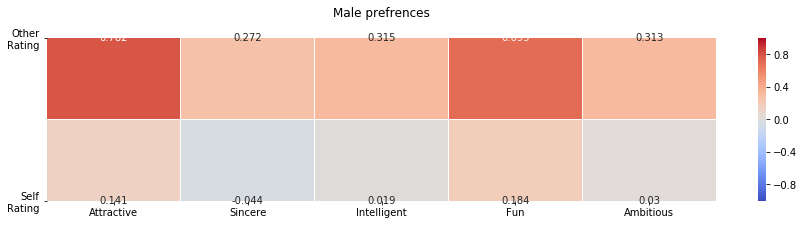

In [23]:
plotPrefByCat('gender',allRatings,{0:'Female',1:'Male'})
None

race
1     17
2    208
3     32
4     96
6     30
dtype: int64

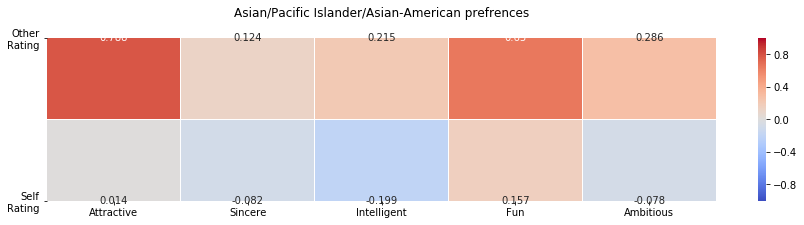

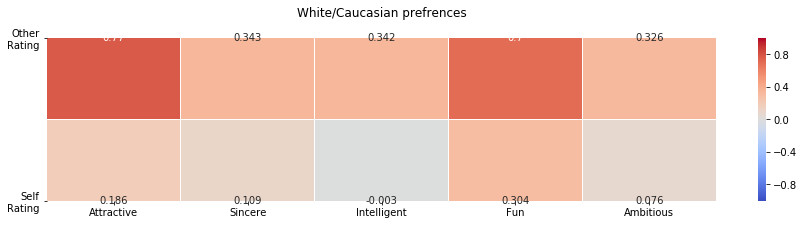

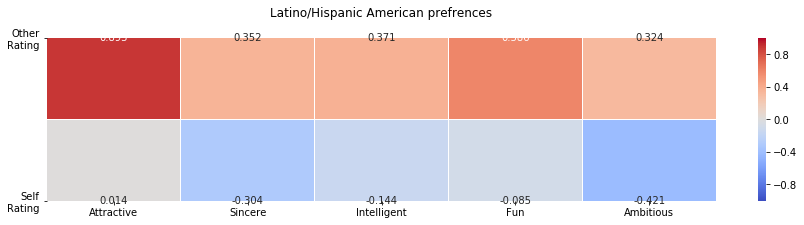

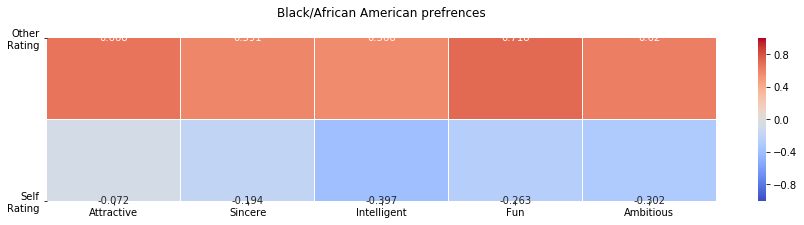

In [24]:
plotPrefByCat('race',allRatings[allRatings['race'] != 6],raceKeys)
None

## Diference in preferences by demographic data

Above I have compared how self ratings of traits and how other people's average rating of the participant correlate with that participants ratio of other saying yes to date them.

Interestingly and against my initial hypothesis, both men and women seem to value traits equally.

I also did a preference by race plot, but the sample size was quite low and these results may not be representative of the population. Interestingly, African Americans valued their partners being Sincere, Intelligent and Ambioutus while be more likley to dislike those who self rated on these traits highly. This may be evidence of a cultural dislike of arrogance but with a sample of 30 it is hard to come to a viable conclusion.

It is worth noting that asking partners to rate the "attractiveness" of their partner may not act as one would expect. It may not be physical attractiveness, but instead what ever the person rating finds desirable. As a result, it may act as a proxy for that persons preferences. For example person 1 may value intelligence where as person 2 may value ambition and their rating of "attaciveness" may just be a weighted sum of their preferences resulting in them rating people they like as on average more "attractive" but it meaning 2 different things to each person.

In [25]:
from scipy import stats

def tryRename(feild,val):
    if feild == 'gender':
        return genderKeys[val]
    elif feild == 'race':
        return raceKeys[val]
    elif feild == 'career_c':
        return feildKeys[val]
    return val

def significant(pVal,Ci):
    return (-Ci < pVal < Ci)

def sampleTest(pop,sub,Ci=0.05):
    res = stats.ttest_ind(sub,pop) #assuming equal variance
    return [res[0],res[1],significant(res[1],Ci),sub.count()]

def testAllFromGen(catVar,var,df):
    categories = df[catVar].unique()
    categories = categories[~np.isnan(categories)]
    
    slices = [df[df[catVar] == e] for e in categories]
    slices = [s for s in slices if s.shape[0] > 2]
    return pd.DataFrame.from_dict({tryRename(catVar,name):sampleTest(df[var],s[var]) for s,name in zip(slices,categories)},
                                 orient='index',
                                  columns = ['T-Value','P-Value',"Significant","Sample Size"]
                                ).sort_values('P-Value')
    
display(testAllFromGen('gender','matchRatio',allRatings))
display(testAllFromGen('race','matchRatio',allRatings))
display(testAllFromGen('career_c','matchRatio',allRatings)[:-3])


,T-Value,P-Value,Significant,Sample Size
Female,2.405759,0.016456,True,190
Male,-2.401467,0.016646,True,193


,T-Value,P-Value,Significant,Sample Size
Asian/Pacific Islander/Asian-American,-2.785825,0.005552,True,96
White/Caucasian,1.740550,0.082285,False,208
Latino/Hispanic American,0.718640,0.472769,False,32
Other,-0.467913,0.640095,False,30
Black/African American,-0.360957,0.718323,False,17


,T-Value,P-Value,Significant,Sample Size
Engineering,-1.393538,0.164245,False,12
"Education, Academia",0.844096,0.399112,False,26
Law,0.726048,0.468212,False,41
English/Creative Writing/ Journalism,-0.707348,0.479744,False,37
Social Work,-0.704919,0.481286,False,5
"Medical Science, Pharmaceuticals, and Bio Tech",0.678771,0.497676,False,18
Biological Sciences/Chemistry/Physics,-0.477743,0.633096,False,17
Film,-0.318810,0.750040,False,13
"Social Science, Psychologist",-0.162557,0.870951,False,13


## Demographic impact on match ratio

In order to see if demographic details such as gender, race and field of work impacted match ratio, I used a 2 sample p-tests to see if any significant differences existed.

Unfortunately, with the small sample size of participants all of the observations failed a 95% confidence interval but I left in these results none the less.

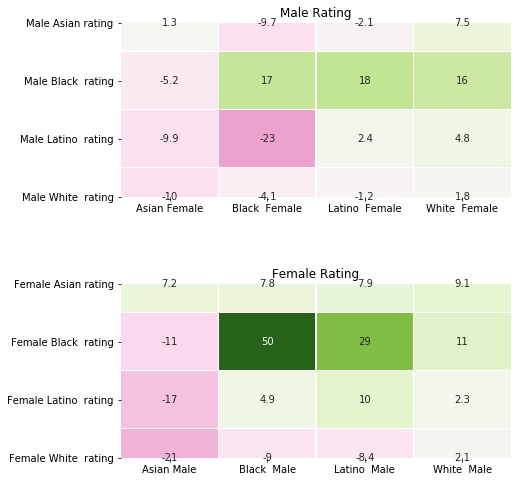

In [26]:
def shortRename(feild,name):
    if name == 4:
        return "Asian"
    res = re.search("^.*/",tryRename(feild,name))
    return (res.group().replace("/"," ") if res != None else tryRename(feild,name))

fig, axArr = plt.subplots(2,1,figsize=(7,8),gridspec_kw=dict(hspace=0.5))   
for g in [1,0]:
    sli = sdPruned[(sdPruned['gender'] == g) & (sdPruned['race'] !=6)] #6 is other i droped these as they dont tell us much
    mean = sli['dec'].mean()
    res = sli.groupby(['race','race_o'])['dec'].mean().unstack().drop(6,axis=1)
    res.columns = [shortRename('race',e) for e in res.columns.values]
    res.index = res.columns.values
    res = res.sort_index()
    res = res[res.index.values]
    res = res.applymap(lambda x : (x - mean)*100)
    res.index = [tryRename('gender',g) +" "+ e + " rating" for e in res.index.values]
    invG = 0 if g == 1 else 1
    res.columns = [e +" "+tryRename('gender',invG) for e in res.columns.values]
    sns.heatmap(res,cmap='PiYG',annot=True,vmin =-50, vmax=50,linewidths=0.1,ax=axArr[invG],cbar=False).set_title(tryRename('gender',g) + " Rating")
    
plt.show()


![image](https://miro.medium.com/max/990/1*3IpLVOKV0cxUkhuNXHvA9A.png)

## Race and Attraction

I opted to reproduce the data found in OkCupid's [blog](https://theblog.okcupid.com/race-and-attraction-2009-2014-107dcbb4f060?source=collection_archive---------2-----------------------) image for same year shown above.

To do this, I took the difference between that gender's match ratio (one sided) and what that squares match ratio was. I then multiplied by 100 to get closer values to OkCupid's dataset. There are many ways of calcuating this (such as taking that races + genders match likelyhood rather than just that genders).

It seems the most races had a preference for members of their own race (the same as the OkCupid's dataset), with the exception being asians. It is hard to draw any conclusions as what qualifies as Asian may differ in this data set and both our sample sizes are quite low, and we cant reject the null hypothesis for most of these differences.

In [27]:
display(sdPruned[['int_corr','match']].corr()['int_corr'][1])
# intrests dont seem to be a big predictor

0.03788273613816175

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFECV
from sklearn.ensemble import BaggingClassifier

In [29]:
tree = RandomForestClassifier()

In [30]:
selfPV = [e +"3_s" for e in personalityVector]

inputFeilds = list(otherRatings.columns.values) + interests + expectations + demographic  + partner + scoreCard
for e in ['dec','match','dec_o','career','field','field','undergra','from','like_o']:
    inputFeilds.remove(e) 

In [31]:
modelVars = sdPruned[inputFeilds + ['dec_o']]

naRatio = modelVars.isna().sum()/modelVars.shape[0]
modelVars = modelVars.drop(naRatio[naRatio > 0.1].index.values,axis=1).dropna() 
print(f"dropped:\n\n{naRatio[naRatio > 0.1]}")
#remove all columns with nan rates of > 10%
#then remove any record with a single null in it

def train(df,model):
    df_x =  modelVars.drop('dec_o',axis=1)
    df_y =  modelVars['dec_o']
    
    x_train, x_test, y_train, y_test = train_test_split(df_x.values, df_y,test_size=0.33, random_state=42)
    rfe = RFECV(model,cv=4).fit(x_train,y_train)
    supportCols = df_x.columns[rfe.get_support()].values
    
    x_train, x_test, y_train, y_test = train_test_split(df_x[supportCols].values, df_y,test_size=0.33, random_state=42)
    model.fit(x_train,y_train)
    featureImport = model.feature_importances_
    return model,model.score(x_test,y_test),supportCols,featureImport
    

dropped:

expnum     0.732408
income     0.502973
mn_sat     0.548893
tuition    0.478527
shar_o     0.129006
shar       0.129006
dtype: float64


## Model pruning

For my model I added in mean ratings of each of the score card traits that I was exploring earlier. I then added in the __interest__, __expectation__, __demographic__, __partner__ and __score card__ column values.

I decided to make a model to predict the other participant either matching or not matching with the participant.

After doing this, I dropped all categorical fields with large amounts of categories. I decided to drop any column with a NaN rate higher than 10%, as well as all the columns that either made no sense or should be excluded from the model.

In [32]:
femaleModel =  train(modelVars[modelVars['gender'] == 0].drop('gender',axis=1),tree)
maleModel = train(modelVars[modelVars['gender'] == 1].drop('gender',axis=1),tree)
generalModel = train(modelVars,tree)

In [33]:
def findClass(col):
    if "omr_" in col:
        return "mean other rating"
    elif "pf_o" in col:
        return "partner prefrences"
    elif col == 'int_corr':
        return "interests" 
    for feilds,name in categories:
        if col in feilds:
            return name
    return "Unknown"

for model,name in zip([femaleModel,maleModel,generalModel],["Female","Male","General"]):
    print(f"{name} Model accuracy: {model[1] * 100}%")

Female Model accuracy: 74.19614147909968%
Male Model accuracy: 74.11575562700965%
General Model accuracy: 75.16077170418006%


## Predictive model

For my model's algorithim, I decided to pick one that would would allow me to learn more from the data. As a result a opted for a Random Forrest Classifer, as I could use the "Feature Importances" to see what variables, and what type of variables where important.

After pruning my variables, I implemented a train/test split aswell as cross validated recursive feature elimination (RFECV). I had my models return their accuracy on the unseen test data aswell as what columns where kept after feature elimination.

In [34]:
for model,name in zip([femaleModel,maleModel,generalModel],["Female","Male","General"]):
    print(name)
    display(pd.DataFrame(data = {"Variable Type":[findClass(e) for e in model[2]] , "Importance":model[3]}, index = model[2]).sort_values('Importance',ascending=False))

Female


,Variable Type,Importance
attr_o,partner,0.151315
omr_attr,mean other rating,0.088174
fun_o,partner,0.078858
prob_o,partner,0.060313
omr_fun,mean other rating,0.059895
int_corr,interests,0.051452
omr_intel,mean other rating,0.046592
zipcode,demographic,0.043815
omr_amb,mean other rating,0.040934
omr_sinc,mean other rating,0.040448


Male


,Variable Type,Importance
attr_o,partner,0.173041
fun_o,partner,0.088020
omr_attr,mean other rating,0.081713
omr_fun,mean other rating,0.072954
prob_o,partner,0.065631
int_corr,interests,0.054811
omr_intel,mean other rating,0.053650
omr_amb,mean other rating,0.049029
omr_sinc,mean other rating,0.048343
pf_o_int,partner prefrences,0.043723


General


,Variable Type,Importance
attr_o,partner,0.117567
fun_o,partner,0.099451
omr_attr,mean other rating,0.079381
prob_o,partner,0.058578
omr_fun,mean other rating,0.051129
int_corr,interests,0.041838
pf_o_att,partner prefrences,0.037551
omr_amb,mean other rating,0.037336
zipcode,demographic,0.037036
omr_sinc,mean other rating,0.035320


## Results

Interestingly, demographic data such as career and race were pruned from the predictors in favor of info about the partner, the average perception of the participant, aswell as that participants rating of their date.

Attractiveness seemed to be the most important variable for deciding if a match were to take place followed by ratings of "fun". However, it was how the other person rated their date that was more important (understandable as they are the one making the choice).

After splitting by gender, I found 25% of the feature importance was assigned to mens their dates rating of their dates "Attractiveness" aswell as that date's mean attractiveness. This is a 5% increase from women which amoutned to only 20%.

Specific interests only showed up in the male segment with both TV and hiking being the 2 that made it, however int_corr (how much both participants interests correlated) was ranked as the 6th most important feature for both genders.

# Feature Selecting/Engineer and Dealing with NaNs

The features I have selected for my model includes interests, expectations, demographic and Scorecard features.
After this I had a look at the columns with null values in them. I've decided to just drop the columns that had over 1000 null values in them. This is due to the large count of nulls in them, but also the fact that tuition is that the way they measured tuition is based off another response which was taken from another source. Whereas `income` is essentially calculated by the median household income based on zipcode from the [Census Bureau website](http://venus.census.gov/cdrom/lookup/CMD=LIST/DB=C90STF3B/LEV=ZIP)

In [35]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import time
import statistics
import seaborn as sns

In [36]:
interests =  ["sports" ,"tvsports","exercise","dining","museums","art","hiking","gaming","clubbing",
             "reading","tv","theater","movies","concerts","music","shopping","yoga"]

expectations = ['exphappy','expnum','match_es',
               'goal','imprace','imprelig']

demographic = ['gender','age','field','undergra','race','career_c',
                   'field_cd','zipcode','income','mn_sat','tuition','from']

followUp = [e for e in speedDating.columns.values if re.search("^\S*_\d$",e) != None] + ['length']

selfRating =[e for e in speedDating.columns.values if re.search("^\S*_s$",e) != None]

partner = ([e for e in speedDating.columns.values if re.search("_o",e) != None] + ['samerace','int_corr','match'])

scoreCard = ["attr","sinc","intel","fun","amb","shar","like","prob","met"]

postStudy = ['date','them_cal', 'you_call']

In [37]:
feature_cols = interests + expectations + demographic + scoreCard + ['match']

def fixCols(df): #Some names of occupations in fields were uncapitalised, we want to identify, for example occupations such as 
    df['field'] = df['field'].str.title() #law and Law as the same thing.
    return df

df = pd.read_csv("SpeedDatingPruned.csv") # Using the new .csv file.
df = df[feature_cols]
nans = df.isnull().sum().sort_values(ascending=False)
nans.head()

expnum      4434
mn_sat      3323
income      3045
tuition     2897
undergra    1692
dtype: int64

In [38]:
cols_to_rmv = nans[:5].index
feature_cols = [f for f in feature_cols if f not in cols_to_rmv] #Reupdated feature_cols to match the dropping of columns.
df = df.drop(columns=cols_to_rmv)
nans = df.isnull().sum().sort_values(ascending=False)
display(nans.head(10))

shar        781
zipcode     573
amb         541
match_es    538
met         312
fun         279
prob        258
intel       248
sinc        236
like        205
dtype: int64

In [39]:
nan_columns = nans.index[nans>0] #Gets all the columns that have NaNs in them


def impute_median(df,nan_columns): #Create a function that imputs the medians into all the NaN columns
    df[nan_columns] = df[nan_columns].fillna(df.median())
    return df
df = impute_median(df,nan_columns)
new_nans = df.isnull().sum().sort_values(ascending=False)
print(new_nans.head())

from        54
field       38
reading      0
yoga         0
shopping     0
dtype: int64


In [40]:
categoricals = new_nans.index[new_nans>0] #Gets the columns with NaNs

def encode_categoricals(df,categoricals): #Encodes the categoricals into numeric, nulls become -1
    for c in categoricals:
        df[c] = df[c].astype("category").cat.codes
    return df
df = encode_categoricals(df,categoricals)
print(df.isnull().sum().sort_values(ascending=False).head())

match       0
met         0
exphappy    0
yoga        0
shopping    0
dtype: int64


# No more NaNs!

Now we can finally start building our machine learning model. The purpose of our model is to predict whether or not participants have matched. To do this I believe that using a GBM or random forest would be our best bet at getting an accurate model. Although for the first model I will use something simpler and faster.

# Baseline Model

Below I have created a logistic regression model to establish baseline classification performance. I then go on to use random forest to have a look and compare the accuracy.

In [41]:
feature_cols.remove('match') #Remove match from feature cols as it is a response, not a feature

In [42]:
from sklearn.linear_model import LogisticRegression
def split(df,seed,split_ratio=0.2):
    df_train, df_test = train_test_split(df, test_size=split_ratio, random_state=seed)
    return df_train, df_test

def extract_features(df):
    X = df[feature_cols].values
    return X

def extract_response(df):
    response = 'match'
    y = df[response].values
    return y

def train_logistic_regression(X,y,seed):
    model = LogisticRegression(random_state=seed)
    model.fit(X,y)
    return model

def feature_importance(model, columns): #Gives us a dictionary of feature importances
    importances = model.feature_importances_
    df_importance = pd.DataFrame({
        "feature": columns,
        "importance": importances
    })
    df_importance = df_importance.sort_values(by="importance", ascending=False)
    return df_importance

In [43]:
df_train, df_test = split(df,42)

X_train = extract_features(df_train)
y_train = extract_response(df_train)
X_test = extract_features(df_test)
y_test = extract_response(df_test)
logreg = train_logistic_regression(X_train,y_train,42)

In [44]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    y_score = y_pred_proba[:,1]
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    return(acc, auc)

acc,auc = evaluate_model(logreg,X_test,y_test)
print("Logistic regression accuracy is {} with an roc_auc score of {}".format(acc,auc))

Logistic regression accuracy is 0.82411230388109 with an roc_auc score of 0.7413394864847065


This is quite a good baseline performance for our first model, although we did not cross validate or bootstrap.

In [45]:
def train_random_forest(X,y,seed, n_estimators):
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=5,    
        random_state=seed
    )
    model.fit(X, y)
    return model

In [46]:
df_train, df_test = split(df,42)

X_train = extract_features(df_train)
y_train = extract_response(df_train)
X_test = extract_features(df_test)
y_test = extract_response(df_test)
random_forest = train_random_forest(X_train,y_train,42,100)
random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
rf_importances = feature_importance(random_forest, feature_cols)
print(rf_importances.head(10))

     feature  importance
36      like    0.196311
33       fun    0.113405
35      shar    0.107101
30      attr    0.104624
37      prob    0.087065
18  match_es    0.034956
32     intel    0.031912
31      sinc    0.024436
29      from    0.021743
8   clubbing    0.021528


In [48]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    y_score = y_pred_proba[:,1]
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    return(acc, auc)

acc,auc = evaluate_model(random_forest,X_test,y_test)
print('Accuracy:',acc,'Area under ROC curve:', auc)

Accuracy: 0.82411230388109 Area under ROC curve: 0.8009234431303922


As you can see above, our two models are fairly similar. I would say that the `roc_auc_score` is a better measure of a classifier's performance than `accuracy` because it does not bias on size of test or evaluation data. 
A 0.8527 auc score is very accurate. To add statistical confidence, we can bootstrap or cross validate.

# Bootstrapping

I used bootstrapping as an alternative to cross validation, this adds statistical confidence to our models

In [49]:
# Because the GBM model takes so long on my computer to process, I have created a progress bar to keep track of it as sometimes
#I wouldn't know whether my jupyter notebook had broken or not. 
def print_progress_bar(iteration, total, prefix="", suffix="", length=30, fill="=", head=">", track="."):
    filled_length = int(length * iteration // total)
    if filled_length == 0:
        bar = track * length
    elif filled_length == 1:
        bar = head + track * (length - 1)
    elif filled_length == length:
        bar = fill * filled_length
    else:
        bar = fill * (filled_length-1) + ">" + "." * (length-filled_length)
    print("\r" + prefix + "[" + bar + "] " + str(iteration) + "/" + str(total), suffix, end = "\r")
    if iteration == total: 
        print()
        
#Calculates the average feature importance over all the splits
def calculate_average_feature_importance(importances, n_bootstraps): 
    importances_sorted = [imp.sort_values("feature") for imp in importances] #gives a sorted list of all the 
                                                                            #feature importance dataframes
        
    values = [0 for _ in range(len(importances_sorted[0]))] #Creates a list of 0's of importances length so that we                  
                                                            #can perform aggregations
    for imp in importances_sorted:                          
        imp_vals = imp["importance"].values.tolist()
        for j, val in enumerate(imp_vals):
            values[j] = values[j] + val
    values = [v/n_bootstraps for v in values]
    ave_importance = importances_sorted[0]
    ave_importance.importance = values
    ave_importance = ave_importance.sort_values("importance", ascending=False).reset_index()
    ave_importance = ave_importance[["feature", "importance"]] 
    return ave_importance

In [50]:
mean_auc = []
mean_acc = []
def bootstrap(df, train_function, n_bootstraps, n_estimators, auc_list, acc_list):
    print("\nBootstrapping", train_function.__name__, n_bootstraps, "times...")
    start = time.time()
    accs, aucs, importances = [], [], []
    for i, seed in enumerate(range(n_bootstraps)):
        df_train, df_test = split(df, seed)
        X_train = extract_features(df_train)
        y_train = extract_response(df_train)
        X_test = extract_features(df_test)
        y_test = extract_response(df_test)
        model = train_function(X_train, y_train, seed,n_estimators)
        acc, auc = evaluate_model(model, X_test, y_test)
        importance = feature_importance(model, feature_cols)
        accs.append(acc)
        aucs.append(auc)
        importances.append(importance)
        print_progress_bar(i+1, n_bootstraps)
    acc_mean = statistics.mean(accs)
    acc_stdev = statistics.stdev(accs)
    acc_list.append(acc_mean)
    print("\nacc: mean=" + str(acc_mean), "stdev=" + str(acc_stdev))
    auc_mean = statistics.mean(aucs)
    auc_stdev = statistics.stdev(aucs)
    auc_list.append(auc_mean)
    print("auc: mean=" + str(auc_mean), "stdev=" + str(auc_stdev))
    ave_importance = calculate_average_feature_importance(importances, n_bootstraps)
    print(" ")
    print(ave_importance.head(10))
    best_index = [i for i, auc in enumerate(aucs) if auc == max(aucs)][0] #gives us the best/highest auc value index
    print("\nRun time:", int(time.time() - start), "seconds")
    return (best_index,aucs[best_index], n_bootstraps)

best_index, best_auc, n_bootstraps = bootstrap(df, train_random_forest, 20, 100, mean_auc, mean_acc)


Bootstrapping train_random_forest 20 times...
[==============================] 20/20 

acc: mean=0.8382328654004955 stdev=0.007252978917085859
auc: mean=0.8039991617522869 stdev=0.013419383554274925
 
    feature  importance
0      like    0.195512
1       fun    0.125636
2      attr    0.115223
3      shar    0.100188
4      prob    0.094792
5  match_es    0.034458
6     intel    0.029187
7      from    0.021837
8   zipcode    0.020872
9      sinc    0.020491

Run time: 8 seconds


In [51]:
print('The best seed value/index was {} with {} iterations which gave us an roc auc score of: {}'
      .format(best_index, n_bootstraps, best_auc))

The best seed value/index was 9 with 20 iterations which gave us an roc auc score of: 0.8318435694528988


**Top 10 features in terms of importance:**
1. `like` - This corresponds to a rating on a scorecard that a participant fills after each "date" during the event. The question they must answer is "Overall, how much do you like this person?". The scorecard emphasises that the participant's inputs will be 100% confidental
2. `fun` - Scorecard rating of how fun the participant thought their partner was
3. `attr` - Scorecard rating of how attractive the participant thought their parner was
4. `shar` - Scorecard rating of how many shared interests 
5. `prob` - How probable it is for you to say yes to your partner
6. `match_es` - Estimated number of matches that the participant thinks he/she will get
7. `intel` - Scorecard rating of how intelligent the participant thought their partner was
8. `from` - Where the participant was originally from
9. `sinc` Scorecard rating of how sincere the participant thought their partner was

In [52]:
def train_gbm(X, y, seed, n_estimators): ## Train GBM model
    model = GradientBoostingClassifier(
        learning_rate=0.1, 
        n_estimators=n_estimators, 
        max_depth=5,
        subsample=0.8,
        random_state=seed
    )
    model.fit(X, y)
    return model
best_index, best_auc, n_bootstraps = bootstrap(df, train_gbm, 20, 100, mean_auc, mean_acc)


Bootstrapping train_gbm 20 times...
[==============================] 20/20 

acc: mean=0.8524360033030554 stdev=0.010174000218834965
auc: mean=0.82585404079538 stdev=0.014416495199323994
 
    feature  importance
0      like    0.170434
1      prob    0.072853
2      attr    0.060531
3       fun    0.058861
4      shar    0.053318
5   zipcode    0.051320
6      from    0.043348
7     field    0.038866
8  match_es    0.028428
9  clubbing    0.026660

Run time: 41 seconds


In [53]:
print('The best seed value/index was {} with {} iterations which gave us an roc auc score of: {}'
      .format(best_index, n_bootstraps, best_auc))

The best seed value/index was 9 with 20 iterations which gave us an roc auc score of: 0.8569346105789254


GBMs seem to increase the auc score and accuracy of the model a bit, so it seems they are better for this type of data.
Below I have created a new bootstrap function that does not require the model to have a `.feature_importances_` attribute.
Models like logistic regression and neural networks do not have this attribute.

In [54]:
def bootstrap_noimp(df, train_function, n_bootstraps, mean_auc, mean_acc):
    print("\nBootstrapping", train_function.__name__, n_bootstraps, "times...")
    start = time.time()
    accs, aucs, importances = [], [], []
    for i, seed in enumerate(range(n_bootstraps)):
        df_train, df_test = split(df, seed)
        X_train = extract_features(df_train)
        y_train = extract_response(df_train)
        X_test = extract_features(df_test)
        y_test = extract_response(df_test)
        model = train_function(X_train, y_train, seed)
        acc, auc = evaluate_model(model, X_test, y_test)
        accs.append(acc)
        aucs.append(auc)
        print_progress_bar(i+1, n_bootstraps)
    acc_mean = statistics.mean(accs)
    acc_stdev = statistics.stdev(accs)
    mean_acc.append(acc_mean)
    print("\nacc: mean=" + str(acc_mean), "stdev=" + str(acc_stdev))
    auc_mean = statistics.mean(aucs)
    auc_stdev = statistics.stdev(aucs)
    mean_auc.append(auc_mean)
    print("auc: mean=" + str(auc_mean), "stdev=" + str(auc_stdev))
    print(" ")
    best_index = [i for i, auc in enumerate(aucs) if auc == max(aucs)][0] #gives us the best/highest auc value index
    print("\nRun time:", int(time.time() - start), "seconds")
    return (best_index,aucs[best_index], n_bootstraps)

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def train_nn(X,y,seed):
    model = MLPClassifier(
    hidden_layer_sizes=10,
    alpha=0.0001,
    random_state=seed
    )
    model.fit(X,y)
    return model
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_nn, 20, mean_auc, mean_acc)


Bootstrapping train_nn 20 times...
[==============================] 20/20 

acc: mean=0.7694054500412882 stdev=0.11053451554784625
auc: mean=0.5852006900131268 stdev=0.07049583042217955
 

Run time: 38 seconds


In [56]:
from sklearn.naive_bayes import GaussianNB
def train_gnb(X,y,seed):
    model = GaussianNB()
    model.fit(X,y)
    return model
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_gnb, 20, mean_auc, mean_acc)


Bootstrapping train_gnb 20 times...
[==============================] 20/20  

acc: mean=0.835962014863749 stdev=0.007323762981752512
auc: mean=0.6770404034644272 stdev=0.033897211563753984
 

Run time: 0 seconds


In [57]:
from sklearn.tree import DecisionTreeClassifier
def train_dtree(X,y,seed):
    model = DecisionTreeClassifier(
        random_state=seed,
        min_samples_split=5)
    model.fit(X,y)
    return model
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_dtree, 20, mean_auc, mean_acc)


Bootstrapping train_dtree 20 times...
[==============================] 20/20 

acc: mean=0.8004128819157721 stdev=0.010397309177470929
auc: mean=0.6463383729000783 stdev=0.01892908417956109
 

Run time: 1 seconds


In [58]:
models_used = ['rf', 'gbm','nn','gnb', 'dtree']
model_evaluation = pd.DataFrame({'model':models_used,
                                'mean_acc': mean_acc,
                                'mean_auc': mean_auc,
                                'model_features': 'Expectations'})
model_evaluation

,model,mean_acc,mean_auc,model_features
0,rf,0.838233,0.803999,Expectations
1,gbm,0.852436,0.825854,Expectations
2,nn,0.769405,0.585201,Expectations
3,gnb,0.835962,0.677040,Expectations
4,dtree,0.800413,0.646338,Expectations


In [59]:
feature_cols = interests + demographic + scoreCard + partner
df = pd.read_csv("SpeedDatingPruned.csv")[feature_cols]
nans = df.isnull().sum().sort_values(ascending=False)
nans.head(15)

mn_sat      3323
income      3045
tuition     2897
undergra    1692
shar         781
shar_o       781
zipcode      573
amb_o        541
amb          541
met          312
met_o        312
fun_o        279
fun          279
prob_o       258
prob         258
dtype: int64

In [60]:
# Remove NaN value counts over 1000
cols_to_rmv = nans[:4].index
feature_cols = [f for f in feature_cols if f not in cols_to_rmv] #Reupdated feature_cols to match the dropping of columns.
df = df.drop(columns=cols_to_rmv)
nans = df.isnull().sum().sort_values(ascending=False)

#imputes the medians into the remaining columns
nan_columns = nans.index[nans>0] #Gets all the columns that have NaNs in them
df = impute_median(df,nan_columns)
new_nans = df.isnull().sum().sort_values(ascending=False)
categoricals = new_nans.index[new_nans>0] #Gets the columns with NaNs

def encode_categoricals(df,categoricals): #Encodes the categoricals into numeric, nulls become -1
    for c in categoricals:
        df[c] = df[c].astype("category").cat.codes
    return df
df = encode_categoricals(df,categoricals)
print(df.isnull().sum().sort_values(ascending=False).head())

match       0
int_corr    0
attr        0
from        0
zipcode     0
dtype: int64


In [61]:
feature_cols.remove('match') #Remove match from feature cols as it is a response, not a feature
feature_cols.remove('dec_o')

In [62]:
second_mean_auc = []
second_mean_acc = []
best_index, best_auc, n_bootstraps = bootstrap(df, train_random_forest, 20, 100, second_mean_auc, second_mean_acc)
best_index, best_auc, n_bootstraps = bootstrap(df, train_gbm, 20, 100, second_mean_auc, second_mean_acc)


Bootstrapping train_random_forest 20 times...
[==============================] 20/20 

acc: mean=0.8572667217175888 stdev=0.00788536761333318
auc: mean=0.8582484502669059 stdev=0.007682893139160502
 
  feature  importance
0    like    0.132121
1  like_o    0.129067
2   fun_o    0.083357
3    attr    0.080480
4  attr_o    0.078439
5     fun    0.075690
6  shar_o    0.059931
7    shar    0.058819
8    prob    0.044209
9  prob_o    0.043042

Run time: 9 seconds

Bootstrapping train_gbm 20 times...
[==============================] 20/20 

acc: mean=0.8739884393063584 stdev=0.00791319526883947
auc: mean=0.8785502176273261 stdev=0.008479902595938048
 
    feature  importance
0      like    0.124518
1    like_o    0.121045
2      attr    0.053949
3    attr_o    0.053667
4     fun_o    0.038178
5       fun    0.035062
6      prob    0.033003
7    prob_o    0.032087
8  int_corr    0.028509
9      shar    0.027087

Run time: 57 seconds


In [63]:
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_nn, 20, second_mean_auc, second_mean_acc)
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_gnb, 20, second_mean_auc, second_mean_acc)
best_index, best_auc, n_bootstraps = bootstrap_noimp(df, train_dtree, 20, second_mean_auc, second_mean_acc)


Bootstrapping train_nn 20 times...
[==============================] 20/20 

acc: mean=0.7370355078447564 stdev=0.20668636376403093
auc: mean=0.5871575694481675 stdev=0.054914736455784166
 

Run time: 43 seconds

Bootstrapping train_gnb 20 times...
[==============================] 20/20  

acc: mean=0.835962014863749 stdev=0.007323762981752512
auc: mean=0.7323846187602279 stdev=0.021690159537507324
 

Run time: 0 seconds

Bootstrapping train_dtree 20 times...
[==============================] 20/20     

acc: mean=0.806523534269199 stdev=0.008472581748310087
auc: mean=0.6613671376876064 stdev=0.01391040518112743
 

Run time: 2 seconds


In [64]:
model_evaluation2 = pd.DataFrame({'model':models_used,
                                'mean_acc': second_mean_acc,
                                'mean_auc': second_mean_auc,
                                'model_features':'Partner'})

combined_models = pd.concat([model_evaluation,model_evaluation2])
combined_models

,model,mean_acc,mean_auc,model_features
0,rf,0.838233,0.803999,Expectations
1,gbm,0.852436,0.825854,Expectations
2,nn,0.769405,0.585201,Expectations
3,gnb,0.835962,0.677040,Expectations
4,dtree,0.800413,0.646338,Expectations
0,rf,0.857267,0.858248,Partner
1,gbm,0.873988,0.878550,Partner
2,nn,0.737036,0.587158,Partner
3,gnb,0.835962,0.732385,Partner
4,dtree,0.806524,0.661367,Partner


Below I have created a bar chart to compare my two sets of models. The blue line represents my model that included the participant's expectations going into the project, but excluded their partner's features.
The yellow line represents the model that included the participant's partner's feature infomration, but not the expectations information.

As you can see, the models are quite consistent, but having partner data seems to be highly beneficial in increasing accuracy. GBMs and Neural networks seem to be the top two models for this problem.

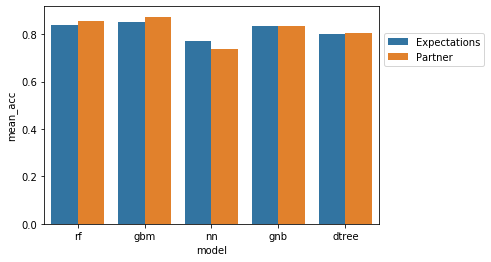

In [65]:
ax = sns.barplot(x="model", y="mean_acc", hue="model_features", data=combined_models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

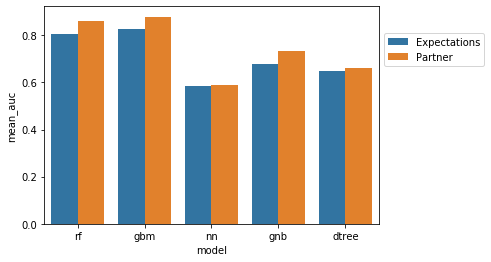

In [66]:
ax = sns.barplot(x="model", y="mean_auc", hue="model_features", data=combined_models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

# The second set of data
This dataset was made from anonymous ratings of 168,791 profiles from 135,359 users of a Czech dating website called [LiBimSeTi](https://libimseti.cz/). This data was collected on April 4th, 2006 and it is a less detailed, but much larger data set than the speed dating data we used previously.

**Data cleaning**
The data is in the form of dat files, which are not possible to import directly as a dataframe, instead it can be imported as a list.

The list gives every single rating that each person gave to each person that they rated. This data although intereseting is far to large to analyse in a convenient manner.

Instead we can look at summary statistics, like the number of people that each person rated, the mean rating and the standard deviation of the ratings.

In [67]:
datRating = [i.strip().split() for i in open(r"secondary_data/ratings.dat").readlines()]
fullList = []    
this = datRating[1]
currentPerson = 1
currentList = [] 
i = 0
sumOfRatings = 0
numOfRatings = 0
max_person = 0
while i < len(datRating):
    cur = datRating[i][0]
    thisSet = cur.split(",")
    
    if int(thisSet[0]) == currentPerson:
        currentList.append(int(thisSet[2]))
    else:
        thisOne = [currentPerson, len(currentList), statistics.mean(currentList), statistics.pstdev(currentList)]
        j = 1
        while j < 11:
            thisOne.append(currentList.count(j) / len(currentList))
            j = j+1
        fullList.append(thisOne)
        currentList = []
        currentPerson =  int(thisSet[0])
        i = i - 1
    i = i+1

Gender is stored in a second file.

In [68]:
gender = [i.strip().split() for i in open(r"secondary_data/gender.dat").readlines()]
gender_proper = []
k = 0
while k < len(gender):
    current = gender[k][0].split(",")
    gender_proper.append([int(current[0]), current[1]])
    k = k + 1

These can then be merged into a single dataframe.

In [69]:
rating_stats_df=pd.DataFrame(fullList, columns = ['ID','Count','Mean', 'Std_dev', 'r1','r2','r3','r4','r5','r6','r7','r8','r9','r10'])

gender_df = pd.DataFrame(gender_proper, columns = ['ID','gender'])

rating_gender = rating_stats_df.merge(gender_df, how = 'left', left_on = 'ID', right_on = 'ID')

As the original ratings.dat file is to large to upload to github, even when zipped rating_gender was saved as a csv, compressed and uploaded as an alterantive method. The below line gets the informaiton that is generated above from a zipfile in the github file.

In [70]:
import zipfile
with zipfile.ZipFile(r'secondary_data/summary_data.zip') as z:
   with z.open('summary_data.csv') as f:
      rating_gender = pd.read_csv(f, header=0, delimiter=",")

There are a small number of people with the gender undefined, these are removed as they are not useful, just missing data

In [71]:
rating_gender = rating_gender.loc[rating_gender['gender'] != 'U']
Male = rating_gender.loc[rating_gender['gender'] == 'M']
Female = rating_gender.loc[rating_gender['gender'] == 'F']

# Data visualisation

We can look at the total number of people that each person rated. Unfortunetly as their is a huge variance it cannot be plotted on a normal scale.

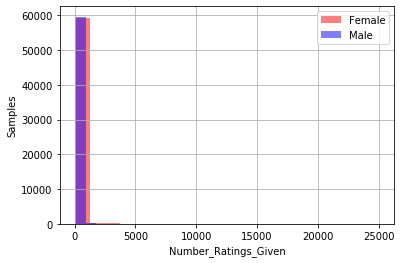

In [72]:
female = Female['Count'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'red', label ='Female')
female.set_xlabel('Number_Ratings_Given')
female.set_ylabel('Samples')
female.legend()
female
male = Male['Count'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'blue', label = 'Male')
male.legend()

A log scale can instead be used so that we can more easily see the summary of the number of people who have given each number of ratings

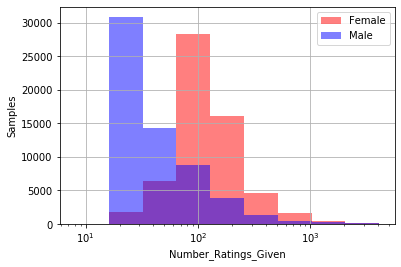

In [73]:
bins = []
j = 0
current = 8
while j<10:
    bins.append(current)
    current = current*2
    j = j + 1

female = Female['Count'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins = bins, color = 'red', label ='Female')
female.set_xlabel('Number_Ratings_Given')
female.set_ylabel('Samples')
female.legend()
female.set_xscale('log')
female
male = Male['Count'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =bins, color = 'blue', label = 'Male')
male.legend()

As can be seen females tend to give a larger number of ratings then men. This is however **not** a useful feature to include in a model, as if the gender is being determined live it would bias the model for people who have just created a profile.

The mean rating that females give to other is higher then for males, which makes this useful to include in a model.

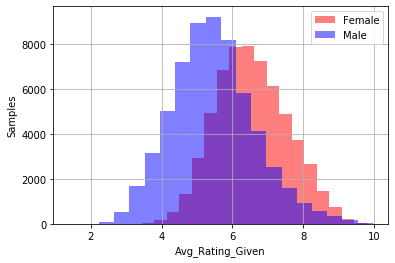

In [74]:
female = Female['Mean'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'red', label ='Female')
female.set_xlabel('Avg_Rating_Given')
female.set_ylabel('Samples')
female.legend()
female
male = Male['Mean'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'blue', label = 'Male')
male.legend()

The variance of the rating that males give to others is higher then for females, which makes this useful to include in a model.

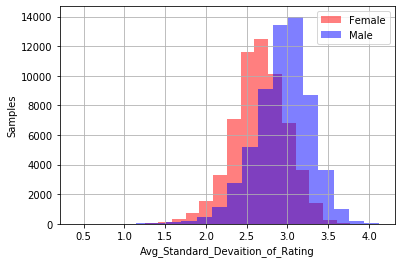

In [75]:
female = Female['Std_dev'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'red', label ='Female')
female.set_xlabel('Avg_Standard_Devaition_of_Rating')
female.set_ylabel('Samples')
female.legend()
female
male = Male['Std_dev'].hist(normed = 0, histtype = 'stepfilled', alpha = 0.5, bins =20, color = 'blue', label = 'Male')
male.legend()

The proportion of each rating given gender is shown below, there is differneces across the gender, especially at the extrem ratings

<function matplotlib.pyplot.show(*args, **kw)>

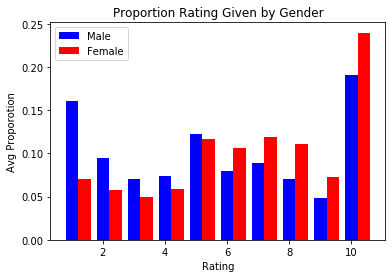

In [76]:
import numpy as np

X = np.arange(1,11) 
plt.bar(x = X, height = Male.iloc[:,4:14].mean()[0:10],width = 0.4, color = 'blue', label = 'Male')
plt.bar(x = X +0.4, height = Female.iloc[:,4:14].mean()[0:10],width = 0.4, color = 'red', label = 'Female')
plt.xlabel('Rating')
plt.ylabel('Avg Proporotion')
plt.title('Proportion Rating Given by Gender')
plt.legend()
plt.show

# Modelling Gender by Using Ratings
First the data must be split inot training and test data. As there is a lot of data including a large amount in the training set will slow the model builidng down to much, so most of the data will be resevrved for only testing.

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rating_gender.iloc[:,2:14],rating_gender.iloc[:,14], test_size = 0.95)

**Model Choice**
Three basic models will be checked to find the best one to use, K Nearest Neighbours, Guassian Naive Bayes and a Neural Network, using a MLPClassifier will be evaluated.

In [78]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


y_pred_train = knn.predict(X_train)


print("for KNN the accuracy for the test data is: " + str(metrics.accuracy_score(y_test,y_pred)))
print("for KNN the accuracy for the training data is: " + str(metrics.accuracy_score(y_train,y_pred_train)))

from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)

y_pred = GNB.predict(X_test)


y_pred_train = GNB.predict(X_train)


print("for GNB the accuracy for the test data is: " + str(metrics.accuracy_score(y_test,y_pred)))
print("for GNB the accuracy for the training data is: " + str(metrics.accuracy_score(y_train,y_pred_train)))

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

y_pred_train = mlp.predict(X_train)

print("for MLP the accuracy for the test data is: " + str(metrics.accuracy_score(y_test,y_pred)))

print("for MLP the accuracy for the train data is: " + str(metrics.accuracy_score(y_train,y_pred_train)))

for KNN the accuracy for the test data is: 0.7188680239605109
for KNN the accuracy for the training data is: 0.7867156208277704
for GNB the accuracy for the test data is: 0.7714177806664676
for GNB the accuracy for the training data is: 0.7703604806408545
for MLP the accuracy for the test data is: 0.827533507825812
for MLP the accuracy for the train data is: 0.829105473965287


**Improving the Model**

The number of iterations required, the ideal hidden units, the best sovler to use and the approptiate alpha will be evaluated.

In [79]:
max_iter_test = pd.DataFrame(columns=['iterations', 'train_accuracy', 'test_accuracy'])
i = 2
while i <= 10:
    mlp = MLPClassifier(random_state=0, max_iter = i*100)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)

    y_pred_cheat = mlp.predict(X_train)


    max_iter_test.loc[i/2] = [i*100,metrics.accuracy_score(y_train,y_pred_cheat),metrics.accuracy_score(y_test,y_pred)]
    
    i = i + 2
    
max_iter_test.head()

,iterations,train_accuracy,test_accuracy
1.0,200.0,0.829105,0.827534
2.0,400.0,0.858979,0.851125
3.0,600.0,0.855474,0.849957
4.0,800.0,0.855474,0.849957
5.0,1000.0,0.855474,0.849957


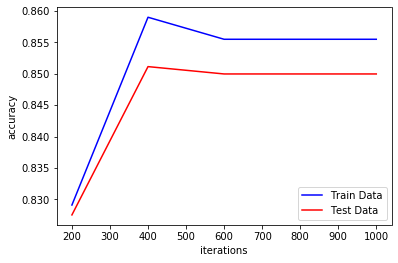

In [80]:
import matplotlib.pyplot as plt
plt.plot(max_iter_test['iterations'],  max_iter_test['train_accuracy'], color = 'blue', label = 'Train Data')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.plot(max_iter_test['iterations'], max_iter_test['test_accuracy'], color = 'red', label = 'Test Data')
plt.legend()
plt.show()

In [81]:
hidden_layers_test = pd.DataFrame(columns=['hidden_units', 'train_accuracy', 'test_accuracy'])
i = 1
while i <= 10:
    mlp = MLPClassifier(hidden_layer_sizes = i *10, random_state=0)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)

    y_pred_cheat = mlp.predict(X_train)


    hidden_layers_test.loc[i] = [i*10,metrics.accuracy_score(y_train,y_pred_cheat),metrics.accuracy_score(y_test,y_pred)]
    
    i = i + 1
    
hidden_layers_test.head(10)

,hidden_units,train_accuracy,test_accuracy
1,10.0,0.763852,0.764295
2,20.0,0.769693,0.773868
3,30.0,0.764352,0.761431
4,40.0,0.766355,0.770917
5,50.0,0.805574,0.803187
6,60.0,0.822263,0.815773
7,70.0,0.835948,0.830142
8,80.0,0.828438,0.824635
9,90.0,0.837116,0.830379
10,100.0,0.829105,0.827534


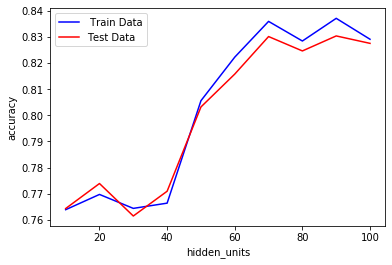

In [82]:
plt.plot(hidden_layers_test['hidden_units'], hidden_layers_test['train_accuracy'], color = 'blue', label = ' Train Data')
plt.xlabel('hidden_units')
plt.ylabel('accuracy')
plt.plot(hidden_layers_test['hidden_units'], hidden_layers_test['test_accuracy'], color = 'red', label = 'Test Data')
plt.legend()
plt.show()

In [83]:
solver_test = pd.DataFrame(columns=['solver', 'train_accuracy', 'test_accuracy'])
i = 1
for x in ['lbfgs','sgd', 'adam']:
    mlp = MLPClassifier(solver = x, random_state=0)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)

    y_pred_cheat = mlp.predict(X_train)


    solver_test.loc[i] = [x,metrics.accuracy_score(y_train,y_pred_cheat),metrics.accuracy_score(y_test,y_pred)]
    i = i + 1
solver_test.head(3)

,solver,train_accuracy,test_accuracy
1,lbfgs,0.762183,0.765305
2,sgd,0.731976,0.733518
3,adam,0.829105,0.827534


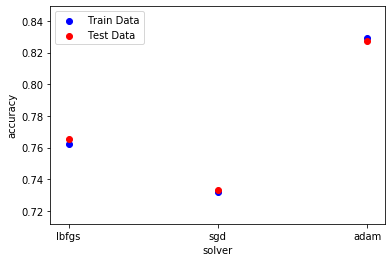

In [84]:
plt.scatter(x = solver_test['solver'], y = solver_test['train_accuracy'], color = 'blue', label = 'Train Data')
plt.xlabel('solver')
plt.ylabel('accuracy')
plt.scatter(x = solver_test['solver'], y = solver_test['test_accuracy'], color = 'red', label = 'Test Data')
plt.legend()
plt.show()

In [85]:
alpha_test = pd.DataFrame(columns=['alpha', 'train_accuracy', 'test_accuracy'])
i = .0001
a = 1
while i <= 1:
    mlp = MLPClassifier(alpha = i *10, random_state=0)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)

    y_pred_cheat = mlp.predict(X_train)


    alpha_test.loc[a] = [i,metrics.accuracy_score(y_train,y_pred_cheat),metrics.accuracy_score(y_test,y_pred)]
    
    i = i *10
    a = a + 1
alpha_test.head(5)

,alpha,train_accuracy,test_accuracy
1,0.0001,0.834446,0.830142
2,0.0010,0.831442,0.827261
3,0.0100,0.799733,0.799015
4,0.1000,0.734479,0.735793
5,1.0000,0.705774,0.710375


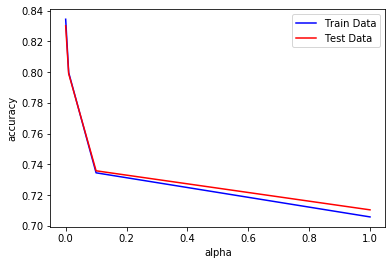

In [86]:
plt.plot( alpha_test['alpha'], alpha_test['train_accuracy'], color = 'blue', label = 'Train Data')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.plot(alpha_test['alpha'], alpha_test['test_accuracy'], color = 'red', label = 'Test Data')
plt.legend()
plt.show()

In [87]:
mlp = MLPClassifier(alpha = .0001, solver = 'adam',hidden_layer_sizes =100, max_iter = 600, random_state=0)
mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

y_pred_train = mlp.predict(X_train)

print("for MLP the accuracy for the test data is: " + str(metrics.accuracy_score(y_test,y_pred)))

print("for MLP the accuracy for the train data is: " + str(metrics.accuracy_score(y_train,y_pred_train)))

for MLP the accuracy for the test data is: 0.8499569624255625
for MLP the accuracy for the train data is: 0.8554739652870494


# Conclusion
Using the best values for each of the evaluated fields improves the accuracy on the test data to nearly 85%, meaning that 85% of the time using the ratings that each person gave can gbe used to find their gender.

**Further Studies**

This information in itself is not overly interesting, however if further demographic information was available from dating profiles it would be interesting to study the realtionship between other factors and the ratings given out and the ratings received.